# Insurance Cross Sell Learn to Rank Project

## 1. Packages

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
sns.set_style('darkgrid')

## 2. Data Reading

In [1]:
data = pd.read_csv('../Data/train.csv')

In [2]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3. Data Description

### 3.1 Rename Columns

For the sake of standardization, all column will jave their name converted to a Snake Case format.

In [11]:
lower = lambda x: x.lower()
data.columns = list(map(lower,data.columns))

### 3.2 Data Dimesionality

In [18]:
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Number of Rows: 381109
Number of Columns: 12


### 3.3 NaN's

In [19]:
data.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

There's no presence of NaN values on the dataset, which is a good sign.

### 3.4 Data Types

In [21]:
data.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

At a first glance, the original data types seems reasonable. Some transformations, like converting gender to a binary column, are desired, but will be implemented in future sections.

### 3.5 Statistical Description

To end this section, some simple statistical analysis are proposed on data. For this, numerical and categorical features will be treated separately.

In [24]:
numerical_features = ['age','annual_premium','vintage']
categorical_features = ['gender','driving_license','region_code','previously_insured','vehicle_age','policy_sales_channel','response']

For the Numerical Features some aggregated statistics are calculated for each column.

In [27]:
data[numerical_features].describe()

,age,annual_premium,vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


For the categorical features, charts of the distribution of some columns can be a great idea to obtain a first glance of the data. For this initial analysis, let's check the distributions of "Driving License","Previously Insured" and "Vehicle Age".

C:\Users\andre_\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

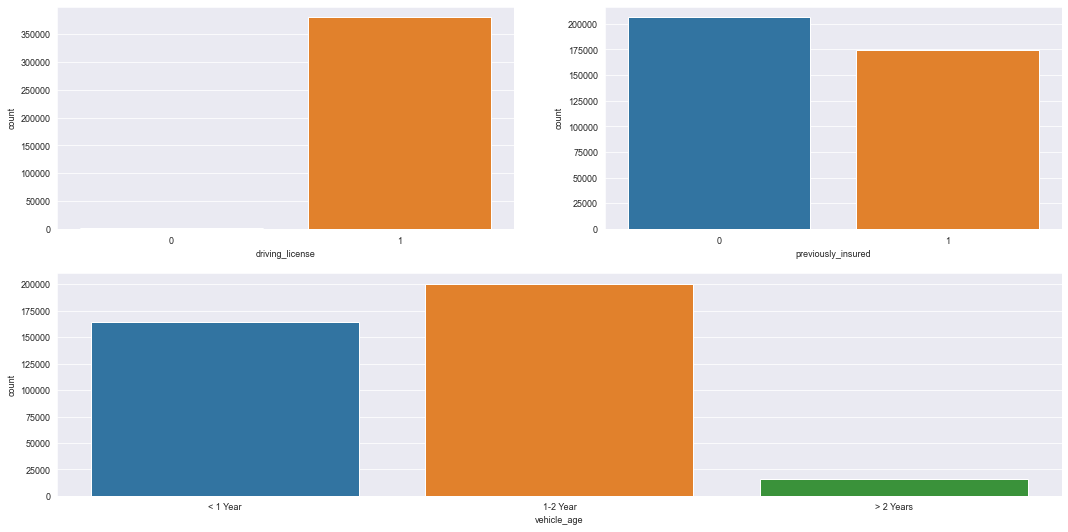

In [55]:
grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.countplot(x='driving_license',data=data)

plt.subplot(grid[0,1])
sns.countplot(x='previously_insured',data=data)

plt.subplot(grid[1,:])
sns.countplot(data['vehicle_age'],order=['< 1 Year','1-2 Year','> 2 Years'])

The "Driving License" plot, on the upper left shows that almost all the customers on the dataset have a driving license, which is a very desired behaviour for this problem. On the upper right, "Previously Insured" presents a balanced distribution. On the lower part, the "Vehicle Age" shows that actually most of the cars of the customers are new cars, which seems to also be a desired feature for a vehicle insurance customer.